In [ ]:
'''
【项目12】  中国城市资本流动问题探索

数据：全国2013-2016所有企业间的投融资信息数据

作业要求
1、查看全国城际控股型投资关系
要求：
① 通过“data.xlsx”导出csv后，直接通过gephi看全国投资情况，有什么发现？
② 分别筛选出“同城投资”、“跨城投资”的TOP20，比较一下两类投资的数据分布
   ** 按照2013-2016年的汇总数据来计算
   ** 分开比较2013-2016四个年度的数据
   ** 需要绘制柱状图来辅助分析，这里用matplotlib即可
提示：
① 原始数据中，同一年中的投资数据会重复记录，所以需要将数据以'投资方所在城市','融资方所在城市','年份'这三个字段做一个分组汇总
② 用df.plot(kind = 'bar')来绘制图表，这里index为城市名即可

2、2013-2016年全国跨城市资本流动情况
要求：
① 结合“中国城市代码对照表.xlsx”数据，给2013-2016年“跨城投资”的汇总数据添加城市的经纬度
② 通过2013-2016年“跨城投资”的汇总数据，在gephi中绘制“城市关系图”
   ** 这里gephi中“点标签”只显示投资笔数TOP20的城市
③ 通过2013-2016年“跨城投资”的汇总数据，在echarts中绘制“全国跨城市资本流动OD图”
   ** 这里通过qgis的插件，做点转线
   ** 通过echart制作最后的资本
   ** 这里line的value为投资笔数
提示：
① 添加经纬度时，“投资方所在城市”、“融资方所在城市”都需要匹配城市经纬度
   ** 需要将“区/县”中最后一个字去掉
② gephi制图所需要导出的csv参考课程资料里的模板：边文件 → edge_model.csv；点文件 → node_model.csv（主要注意列名）
   ** 其中边数据的value需要做标准化处理 → 0-1之间
   ** gephi中单独显示某些城市的点标签方法 → 导入数据后，设置label，然后用label来显示标签，其中label只标注top20的数据
③ qgis中需要安装插件“LinePlotter”来转线
④ shapefile转geojson时：注意shapefile保持wgs84地理坐标系

3、深挖跨城市资本流动：钱从哪里来，到哪里去？
要求：
① 近四年对外控股型投资笔数最多的10个城市是哪些？
② 近四年吸引对外控股型投资笔数最多的10个城市又是哪些？
③ 从2013年到2016年，资本流动两大阵营的变化趋势：“北上深阵营”、“本地化阵营”
   ** “北上深阵营”：最大的外来投资方为北上深之一的城市
   ** “本地化阵营”：这里简化计算，将非“北上深阵营”都划入“本地化阵营”
   ** 该问题从“北上深阵营”历年来城市数量占比来看
   ** 可以qgis辅助绘制城市空间分布
提示：
① 资本流动两大阵营在计算中，主要以“融资方所在城市”为对象研究
② 资本流动两大阵营变化趋势计算中，可以构建函数，以年份为参数
③ 如何得到某年融资城市对应的最大的外来投资城市？
   ** 首先按照“融资方所在城市”做groupby分组，计算“投资企业对数”的max，得到一个Series
   ** Series通过reset_index转化为dataframe
   ** 再通过和源数据merge，找到该融资城市的最大外来投资对应的“投资方城市”，这里merge中的参数 on = ['融资方所在城市','投资企业对数']
④ 为了在qgis中制图，需要给数据添加经纬度信息，这里只需要添加“融资方所在城市”的经纬度
⑤ 为了qgis更好识别阵营类型，数据“阵营”字段用数字表示：0代表“本地化阵营”，1代表“北上深阵营”
⑥ qgis中制图时，既不属于“本地化阵营”又不属于“北上深阵营”的城市，颜色填充和“本地化阵营”一样即可

'''

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore') 
plt.rcParams['font.sans-serif'] = ['SimHei'] 


In [29]:
# 作业要求
# 1、查看全国城际控股型投资关系
# 要求：
# ① 通过“data.xlsx”导出csv后，直接通过gephi看全国投资情况，有什么发现？
# ② 分别筛选出“同城投资”、“跨城投资”的TOP20，比较一下两类投资的数据分布
#    ** 按照2013-2016年的汇总数据来计算
#    ** 分开比较2013-2016四个年度的数据
#    ** 需要绘制柱状图来辅助分析，这里用matplotlib即可
# 提示：
# ① 原始数据中，同一年中的投资数据会重复记录，所以需要将数据以'投资方所在城市','融资方所在城市','年份'这三个字段做一个分组汇总
# ② 用df.plot(kind = 'bar')来绘制图表，这里index为城市名即可

_data = pd.read_excel(r'D:\BaiduNetdiskDownload\项目12中国城市资本流动问题探索\data.xlsx')
data = _data.groupby(['投资方所在城市','融资方所在城市','年份']).sum()
data.reset_index(inplace=True)
for i in data.columns:
    data[i]=data[i].replace(' ','')
data_tc=data[data['投资方所在城市']==data['融资方所在城市']]
data_kc=data[data['投资方所在城市']!=data['融资方所在城市']]
data_tc_sum=data_tc.groupby(['投资方所在城市','融资方所在城市']).sum()['投资企业对数'].sort_values(ascending=False).reset_index()
data_tc_sum.iloc[:20]

,投资方所在城市,融资方所在城市,投资企业对数
0,深圳,深圳,92065
1,北京,北京,91391
2,上海,上海,84298
3,南京,南京,23873
4,杭州,杭州,23791
5,成都,成都,20639
6,广州,广州,20534
7,苏州,苏州,16768
8,武汉,武汉,16404
9,宁波,宁波,13108


In [40]:
data_kc_sum=data_kc.groupby(['投资方所在城市','融资方所在城市'])['投资企业对数'].sum().sort_values(ascending=False).reset_index()
data_kc_sum.iloc[:20]

,投资方所在城市,融资方所在城市,投资企业对数
0,北京,上海,8065
1,上海,北京,6733
2,北京,深圳,6467
3,北京,天津,4862
4,深圳,北京,4674
5,上海,深圳,3580
6,深圳,上海,3495
7,广州,深圳,3324
8,上海,苏州,2804
9,天津,北京,2736


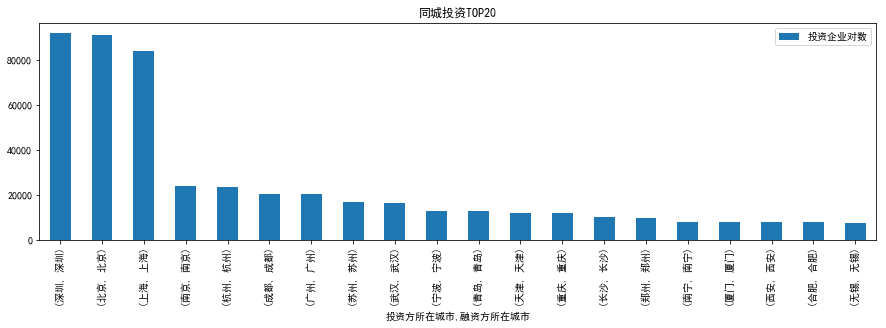

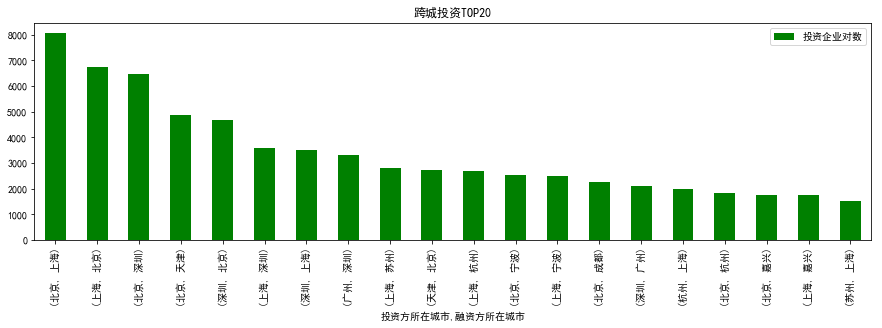

In [46]:
data_tc_sum.iloc[:20].set_index(['投资方所在城市','融资方所在城市']).plot(kind='bar',figsize=(15,4),title='同城投资TOP20')
data_kc_sum.iloc[:20].set_index(['投资方所在城市','融资方所在城市']).plot(kind='bar',color='green',figsize=(15,4),title='跨城投资TOP20')

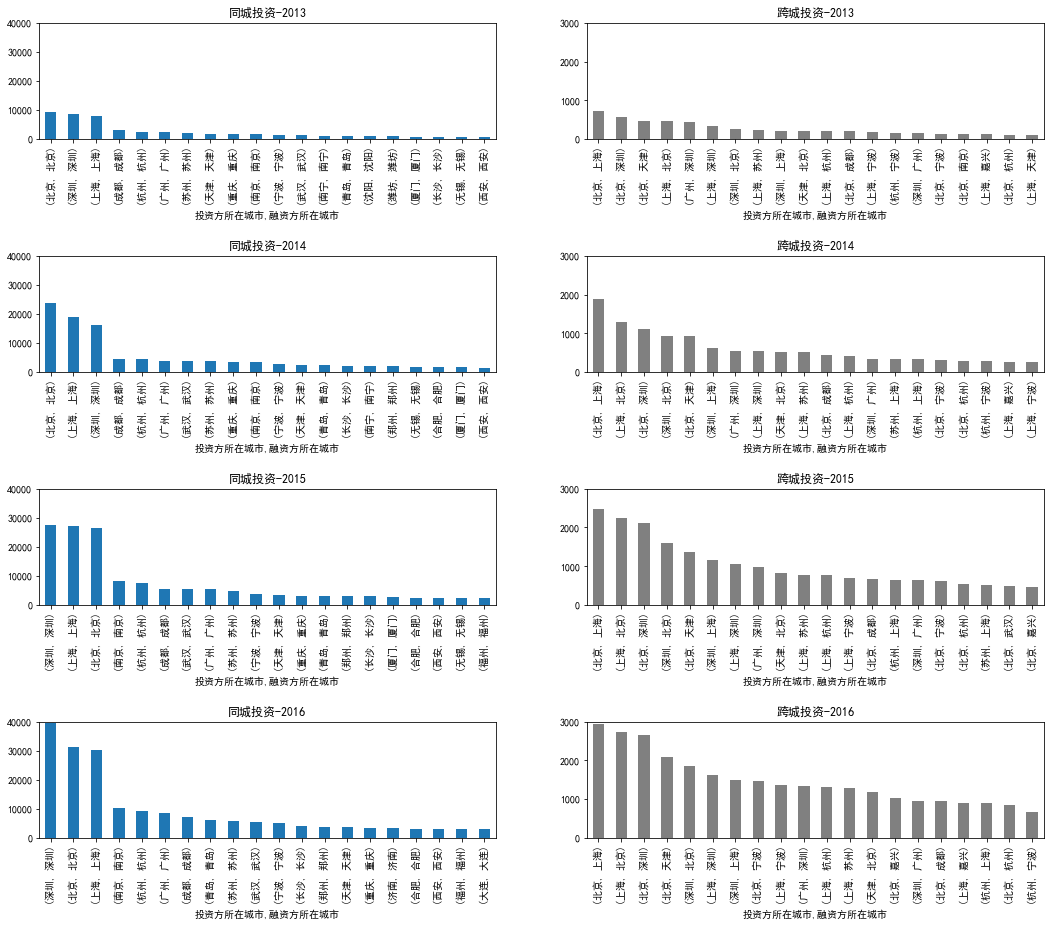

In [93]:
def f(data,year):
    data_y=data[data['年份']==year].groupby(['投资方所在城市','融资方所在城市'])['投资企业对数'].sum().sort_values(ascending=False)

    return data_y.iloc[:20]

fig,axes = plt.subplots(4,2,figsize=(18,15))
plt.subplots_adjust(wspace=0.2,hspace=1)
# 同城投资
f(data_tc,2013).plot(kind='bar',ax=axes[0,0],title='同城投资-2013',ylim=[0,40000])
f(data_tc,2014).plot(kind='bar',ax=axes[1,0],title='同城投资-2014',ylim=[0,40000])
f(data_tc,2015).plot(kind='bar',ax=axes[2,0],title='同城投资-2015',ylim=[0,40000])
f(data_tc,2016).plot(kind='bar',ax=axes[3,0],title='同城投资-2016',ylim=[0,40000])

# 跨城投资
f(data_kc,2013).plot(kind='bar',ax=axes[0,1],title='跨城投资-2013',color='gray',ylim=[0,3000])
f(data_kc,2014).plot(kind='bar',ax=axes[1,1],title='跨城投资-2014',color='gray',ylim=[0,3000])
f(data_kc,2015).plot(kind='bar',ax=axes[2,1],title='跨城投资-2015',color='gray',ylim=[0,3000])
f(data_kc,2016).plot(kind='bar',ax=axes[3,1],title='跨城投资-2016',color='gray',ylim=[0,3000])
fig.show()

In [99]:
# 3、深挖跨城市资本流动：钱从哪里来，到哪里去？
# 要求：
# ① 近四年对外控股型投资笔数最多的10个城市是哪些？
# ② 近四年吸引对外控股型投资笔数最多的10个城市又是哪些？
# ③ 从2013年到2016年，资本流动两大阵营的变化趋势：“北上深阵营”、“本地化阵营”
#    ** “北上深阵营”：最大的外来投资方为北上深之一的城市
#    ** “本地化阵营”：这里简化计算，将非“北上深阵营”都划入“本地化阵营”
#    ** 该问题从“北上深阵营”历年来城市数量占比来看
#    ** 可以qgis辅助绘制城市空间分布
# 提示：
# ① 资本流动两大阵营在计算中，主要以“融资方所在城市”为对象研究
# ② 资本流动两大阵营变化趋势计算中，可以构建函数，以年份为参数
# ③ 如何得到某年融资城市对应的最大的外来投资城市？
#    ** 首先按照“融资方所在城市”做groupby分组，计算“投资企业对数”的max，得到一个Series
#    ** Series通过reset_index转化为dataframe
#    ** 再通过和源数据merge，找到该融资城市的最大外来投资对应的“投资方城市”，这里merge中的参数 on = ['融资方所在城市','投资企业对数']
# ④ 为了在qgis中制图，需要给数据添加经纬度信息，这里只需要添加“融资方所在城市”的经纬度
# ⑤ 为了qgis更好识别阵营类型，数据“阵营”字段用数字表示：0代表“本地化阵营”，1代表“北上深阵营”
# ⑥ qgis中制图时，既不属于“本地化阵营”又不属于“北上深阵营”的城市，颜色填充和“本地化阵营”一样即可

tz_data = data_kc_sum.groupby('投资方所在城市')['投资企业对数'].sum().sort_values(ascending=False)
tz_data.iloc[:10].reset_index()

,投资方所在城市,投资企业对数
0,北京,62284
1,上海,39506
2,深圳,26953
3,杭州,11364
4,广州,8283
5,天津,5598
6,南京,4299
7,成都,4238
8,苏州,4051
9,武汉,3832


In [102]:
rz_data = data_kc_sum.groupby('融资方所在城市')['投资企业对数'].sum().sort_values(ascending=False)
rz_data.iloc[:10].reset_index()

,融资方所在城市,投资企业对数
0,北京,28844
1,上海,26689
2,深圳,21849
3,宁波,8893
4,杭州,8004
5,天津,7111
6,嘉兴,6196
7,苏州,6077
8,成都,6068
9,广州,5698


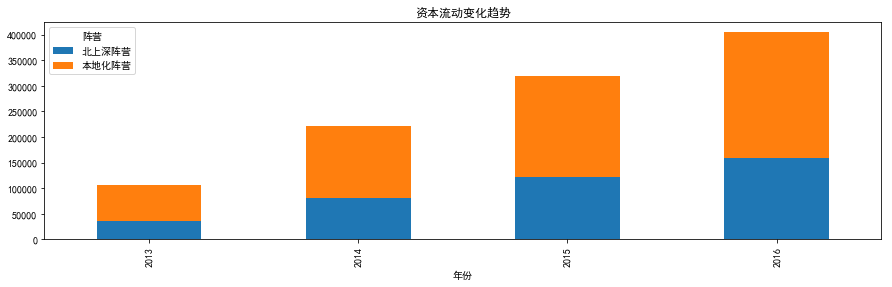

In [128]:
data['阵营']='本地化阵营'
data.loc[(data['投资方所在城市']=='北京')|(data['投资方所在城市']=='上海')|(data['投资方所在城市']=='深圳'),'阵营']='北上深阵营'
data_zy = data.groupby(['年份','阵营'])['投资企业对数'].sum().sort_values(ascending=False).reset_index()
data_bdzy=data_zy[data_zy['阵营']=='本地化阵营']
data_bsszy=data_zy[data_zy['阵营']=='北上深阵营']
data_zy.set_index('年份',inplace=True)

data_zy_pt=pd.pivot_table(data_zy,index='年份',columns='阵营',values='投资企业对数')

data_zy_pt.plot(kind='bar',stacked=True,figsize=(15,4),title='资本流动变化趋势')